In [35]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from utils.plot_functions import *

In [36]:
def plot_binned_residuals_vs_host_dist_grouped(resultados, experiments, titles, cmap_name,
                                               dpi=100, n_bins=5, metric="bias",
                                               use_fill=True, fontsize=10,
                                               markers=None, marker_size=7,
                                               alphas=None):
    """
    metric: "bias" | "nmad"
    - bias = promedio ± std como antes
    - nmad = usa NMAD por bin

    markers: lista con markers para cada experimento
    marker_size: tamaño de los markers (igual para todos)
    alphas: lista con alpha por experimento (misma longitud que experiments)
    """

    def compute_nmad(values):
        """NMAD = 1.4826 * median(|x - median(x)|)"""
        if len(values) == 0:
            return np.nan
        med = np.median(values)
        return 1.4826 * np.median(np.abs(values - med))

    # ----------------------------
    # Preparar markers
    # ----------------------------
    if markers is None:
        markers = ["o"] * len(experiments)
    else:
        if len(markers) != len(experiments):
            raise ValueError("markers debe tener la misma longitud que experiments")

    # ----------------------------
    # Preparar alphas
    # ----------------------------
    if alphas is None:
        alphas = [1.0] * len(experiments)
    else:
        if len(alphas) != len(experiments):
            raise ValueError("alphas debe tener la misma longitud que experiments")

    # ----------------------------
    # 1) Agrupar residuals y hosts
    # ----------------------------
    grouped_host = []
    grouped_residual = []

    for group in experiments:
        host_runs = []
        residual_runs = []

        for key in group:
            mean_preds, original_target = resultados[key]
            residual_pix, host_pix = get_distances(mean_preds, original_target)

            # Convertir a numpy
            if not isinstance(host_pix, np.ndarray):
                host_pix = host_pix.detach().cpu().numpy()
            if not isinstance(residual_pix, np.ndarray):
                residual_pix = residual_pix.detach().cpu().numpy()

            # Pasar a arcsec
            host_runs.append(host_pix * 0.25)
            residual_runs.append(residual_pix * 0.25)

        grouped_host.append(np.vstack(host_runs))
        grouped_residual.append(np.vstack(residual_runs))

    # ----------------------------
    # 2) Bins
    # ----------------------------
    bins = np.linspace(0, 70, n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # ----------------------------
    # 3) Figura
    # ----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=dpi)
    cmap = cm.get_cmap(cmap_name)
    colors = [cmap(v) for v in np.linspace(0.2, 0.8, len(experiments))]

    # ----------------------------
    # 4) Plots
    # ----------------------------
    for normalize_error, ax in zip([False, True], axes):
        for idx, (host_runs, residual_runs) in enumerate(zip(grouped_host, grouped_residual)):
            color = colors[idx]
            marker = markers[idx]
            alpha = alphas[idx]
            n_runs, n_samples = host_runs.shape

            # Normalización si corresponde
            if normalize_error:
                with np.errstate(divide='ignore', invalid='ignore'):
                    residual_runs = np.where(host_runs > 0,
                                             residual_runs / host_runs,
                                             np.nan)

            mean_vals = np.full(n_bins, np.nan)
            std_vals = np.full(n_bins, np.nan)

            # ----------------------------
            # 5) Calcular bias o NMAD
            # ----------------------------
            for b in range(n_bins):
                if b < n_bins - 1:
                    mask = (host_runs >= bins[b]) & (host_runs < bins[b + 1])
                else:
                    mask = (host_runs >= bins[b]) & (host_runs <= bins[b + 1])

                bin_stats = []  # un valor por run

                for r in range(n_runs):
                    vals = residual_runs[r][mask[r]]
                    if vals.size == 0:
                        continue

                    if metric == "bias":
                        stat = np.nanmean(vals)
                    elif metric == "nmad":
                        stat = compute_nmad(vals)
                    else:
                        raise ValueError("metric debe ser 'bias' o 'nmad'")

                    bin_stats.append(stat)

                if len(bin_stats) > 0:
                    mean_vals[b] = np.nanmean(bin_stats)
                    std_vals[b] = np.nanstd(bin_stats)

            valid = ~np.isnan(mean_vals)

            # Línea mean
            ax.plot(bin_centers[valid], mean_vals[valid],
                    "-", lw=1.7, color=color, alpha=alpha)

            # Markers con borde negro y alpha
            ax.plot(bin_centers[valid], mean_vals[valid],
                    linestyle="None",
                    marker=marker,
                    markersize=marker_size,
                    markerfacecolor=color,
                    markeredgecolor="black",
                    markeredgewidth=0.6,
                    alpha=alpha,
                    label=titles[idx])

            # Sombreado o barras de error
            if use_fill:
                ax.fill_between(bin_centers[valid],
                                mean_vals[valid] - std_vals[valid],
                                mean_vals[valid] + std_vals[valid],
                                color=color, alpha=0.25 * alpha)
            else:
                ax.errorbar(bin_centers[valid], mean_vals[valid],
                            yerr=std_vals[valid],
                            fmt="none",
                            ecolor=color,
                            elinewidth=1.3,
                            capsize=3,
                            alpha=alpha)

        metric_symbol = f"$<\\Delta h>$" if metric == "bias" else f"$\\sigma_{{\\mathrm{{MAD}}}}$"

        ax.set_xlim(0, 70)
        if normalize_error:
            ax.set_ylabel(f"{metric_symbol}", fontsize=fontsize, math_fontfamily='cm')
        else:
            ax.set_ylabel(f"{metric_symbol} $['']$", fontsize=fontsize, math_fontfamily='cm')

        ax.set_xlabel(r"$\mathrm{Host\ Dist}\ ['']$", fontsize=fontsize, math_fontfamily='cm')
        ax.grid(True, linestyle="--", alpha=0.4)

    axes[0].legend(loc="upper left", fontsize=10)
    plt.tight_layout()
    plt.show()

## Galaxy identification

In [37]:
resultados = {
              "Baseline": load_preds("baseline_delight_r"),

              "Autolabeling 1% 1": load_preds("autolabeling_delight_r_1_percent_1"),
              "Autolabeling 1% 2": load_preds("autolabeling_delight_r_1_percent_2"),
              "Autolabeling 1% 3": load_preds("autolabeling_delight_r_1_percent_3"),

              "Autolabeling 05% 1": load_preds("autolabeling_delight_r_05_percent_1"),
              "Autolabeling 05% 2": load_preds("autolabeling_delight_r_05_percent_2"),
              "Autolabeling 05% 3": load_preds("autolabeling_delight_r_05_percent_3"),

              "Autolabeling 01% 1": load_preds("autolabeling_delight_r_01_percent_1"),
              "Autolabeling 01% 2": load_preds("autolabeling_delight_r_01_percent_2"),
              "Autolabeling 01% 3": load_preds("autolabeling_delight_r_01_percent_3"),

              "Autolabeling 002% 1": load_preds("autolabeling_delight_r_002_percent_1"),
              "Autolabeling 002% 2": load_preds("autolabeling_delight_r_002_percent_2"),
              "Autolabeling 002% 3": load_preds("autolabeling_delight_r_002_percent_3"),

              "Autolabeling Pasquet 002%": load_preds("autolabeling_pasquet_r_002_percent"),
              }

In [ ]:
galaxy_cross_match = {

    "Original Galaxies": pd.read_csv(
        "../data/SERSIC/df_test_delight_fixed_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Baseline": pd.read_csv(
        "../resultados/baseline_delight_r/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    # === Autolabeling 1% ===
    "Autolabeling 1% 1": pd.read_csv(
        "../resultados/autolabeling_delight_r_1_percent_1/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Autolabeling 1% 2": pd.read_csv(
        "../resultados/autolabeling_delight_r_1_percent_2/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Autolabeling 1% 3": pd.read_csv(
        "../resultados/autolabeling_delight_r_1_percent_3/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    # === Autolabeling 0.5% ===
    "Autolabeling 05% 1": pd.read_csv(
        "../resultados/autolabeling_delight_r_05_percent_1/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Autolabeling 05% 2": pd.read_csv(
        "../resultados/autolabeling_delight_r_05_percent_2/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Autolabeling 05% 3": pd.read_csv(
        "../resultados/autolabeling_delight_r_05_percent_3/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    # === Autolabeling 0.1% ===
    "Autolabeling 01% 1": pd.read_csv(
        "../resultados/autolabeling_delight_r_01_percent_1/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Autolabeling 01% 2": pd.read_csv(
        "../resultados/autolabeling_delight_r_01_percent_2/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Autolabeling 01% 3": pd.read_csv(
        "../resultados/autolabeling_delight_r_01_percent_3/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    # === Autolabeling 0.02% ===
    "Autolabeling 002% 1": pd.read_csv(
        "../resultados/autolabeling_delight_r_002_percent_1/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Autolabeling 002% 2": pd.read_csv(
        "../resultados/autolabeling_delight_r_002_percent_2/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Autolabeling 002% 3": pd.read_csv(
        "../resultados/autolabeling_delight_r_002_percent_3/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    # === Autolabeling Pasquet ===
    "Autolabeling Pasquet 002%": pd.read_csv(
        "../resultados/autolabeling_pasquet_r_002_percent/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),
}



In [39]:
experiments=[
["Baseline"],
["Autolabeling 1% 1","Autolabeling 1% 2","Autolabeling 1% 3"],
["Autolabeling 05% 1","Autolabeling 05% 2","Autolabeling 05% 3"],
["Autolabeling 01% 1","Autolabeling 01% 2","Autolabeling 01% 3"],
["Autolabeling 002% 1","Autolabeling 002% 2","Autolabeling 002% 3"],
["Autolabeling Pasquet 002%"]
]

names = ["Baseline", "Auto-etiquetado 1%", "Auto-etiquetado 0.5%", "Auto-etiquetado 0.1%", "Auto-etiquetado 0.02%", "Auto-etiquetado Pasquet 0.02%"]

In [ ]:
print_group_metrics(resultados, experiments, names)

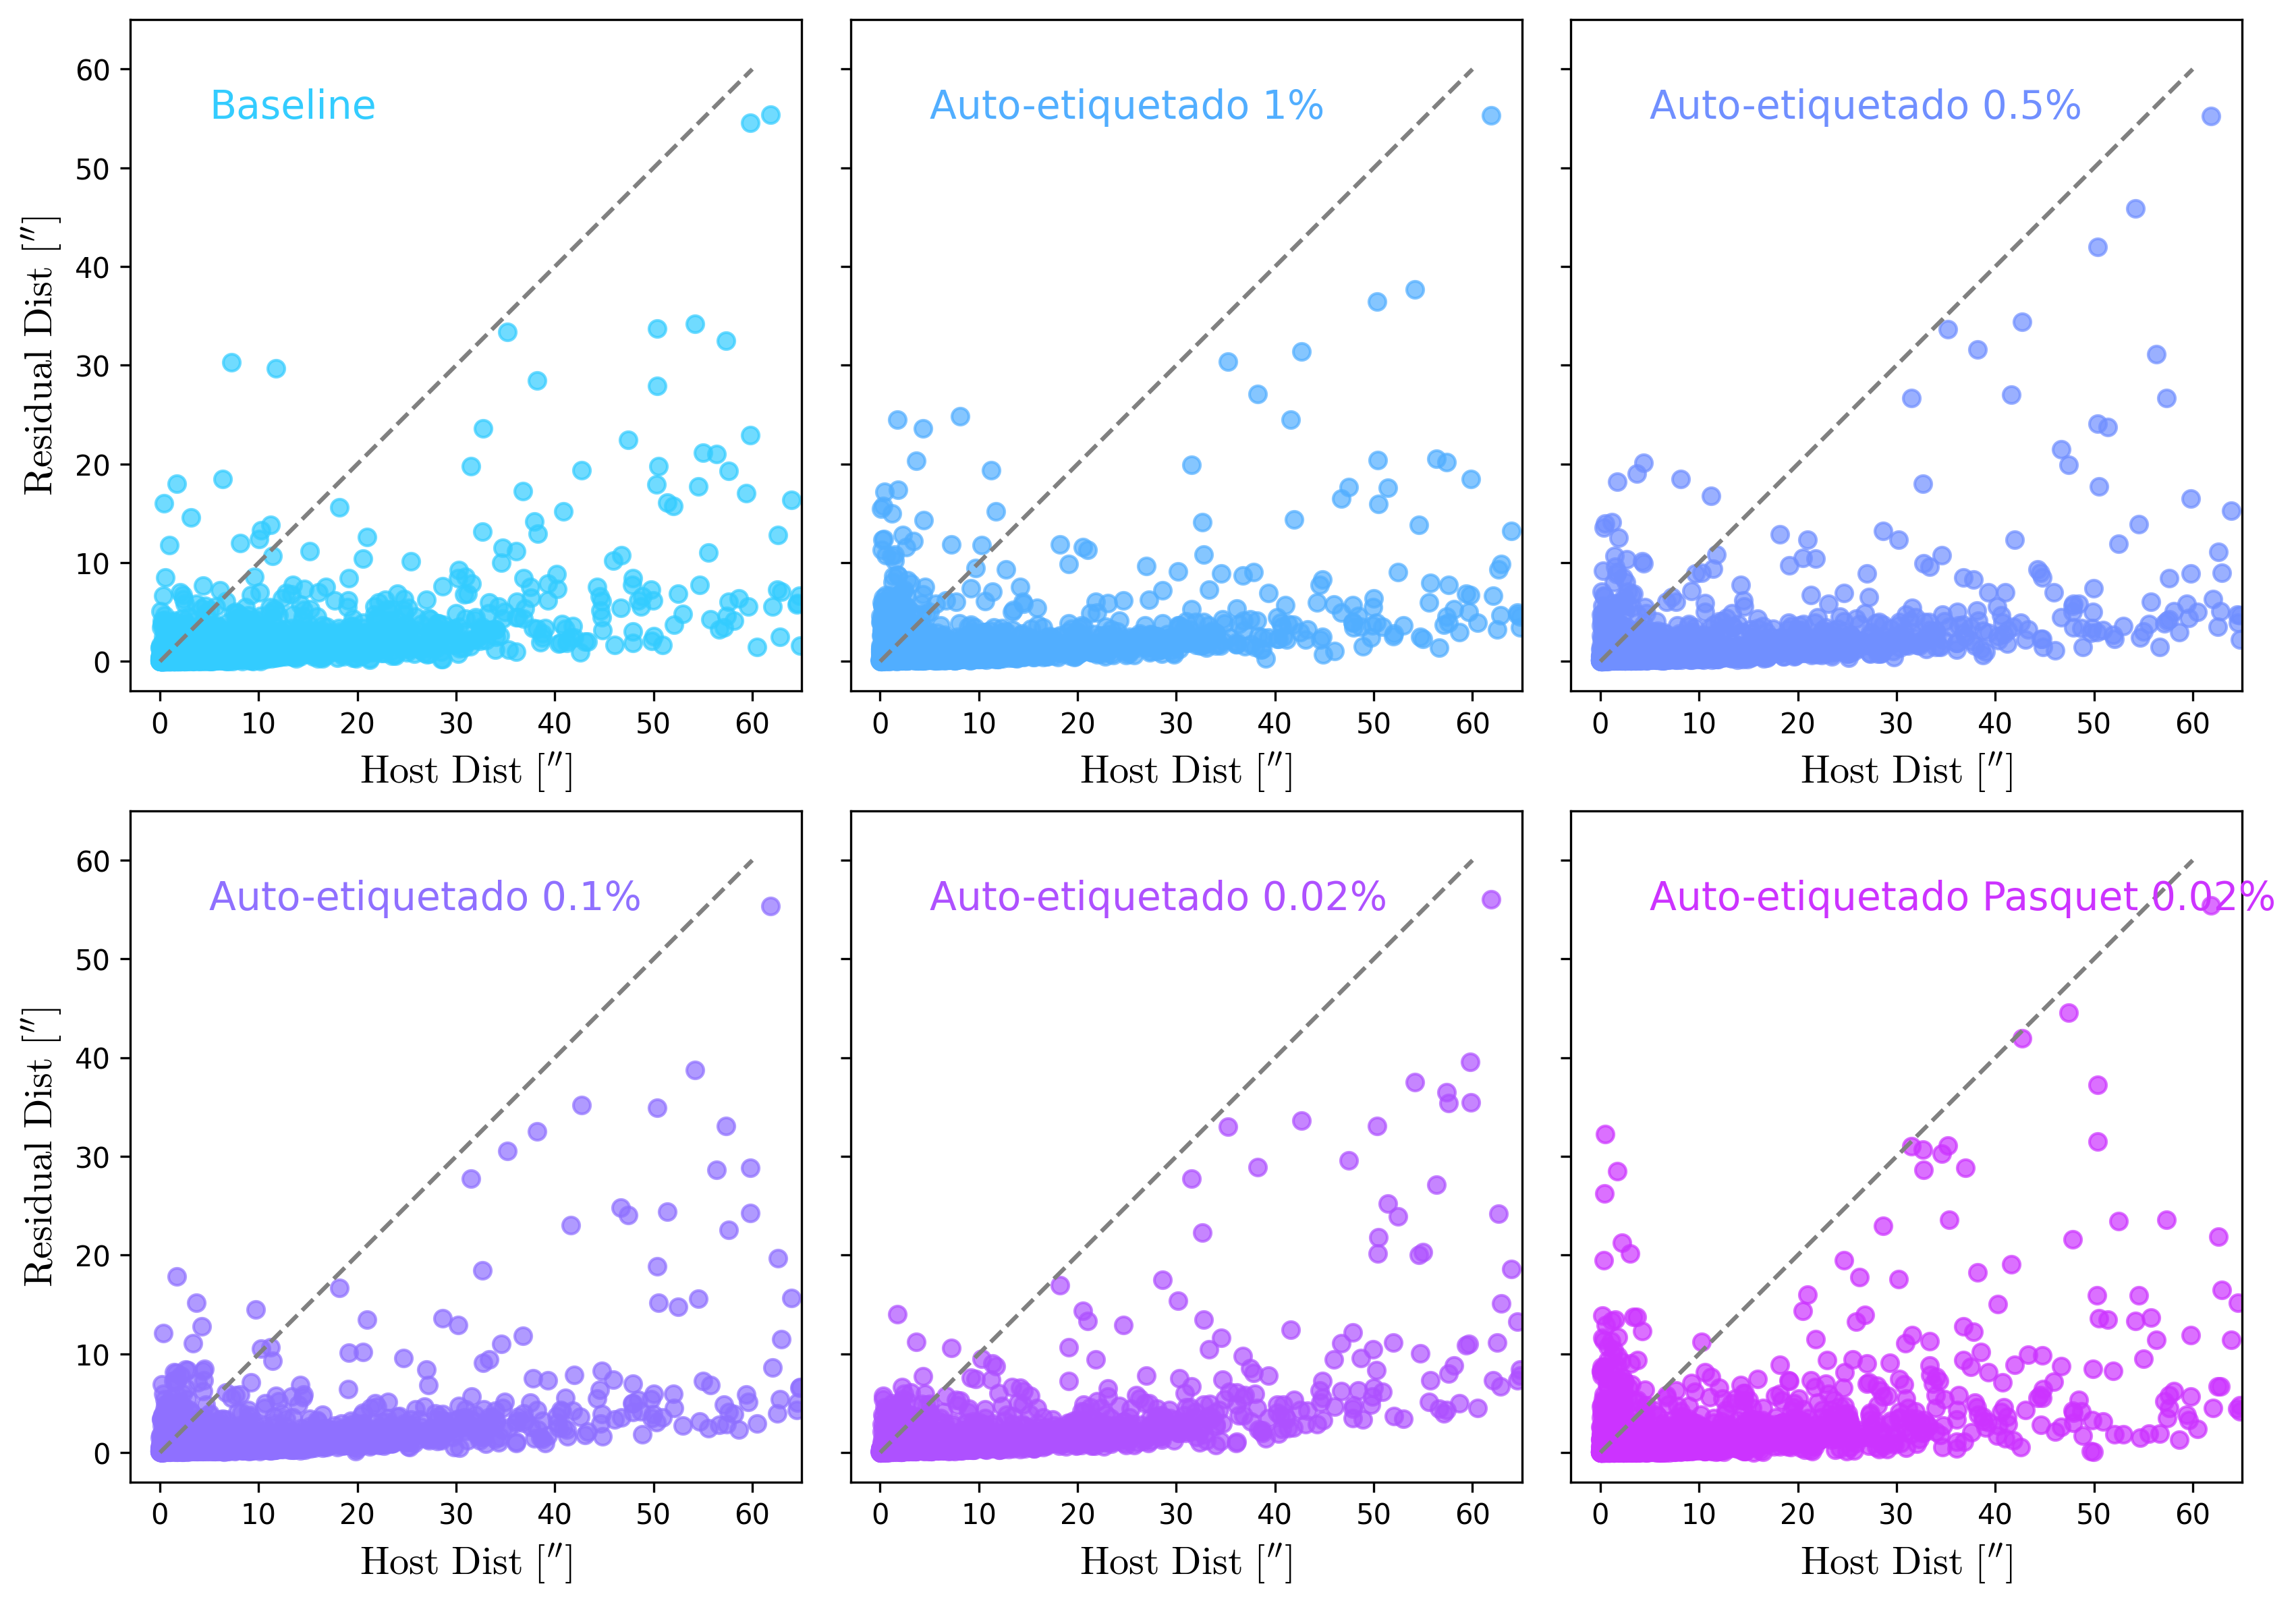

In [40]:
plot_residuals_vs_host_dist_grouped2(resultados, 
                                    experiments=experiments,                                             
                                    titles = names,
                                    cmap_name ="cool",
                                    fontsize=14,
                                    fontsize_title=14,
                                    dpi=300)

/tmp/ipykernel_3747957/2807202205.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


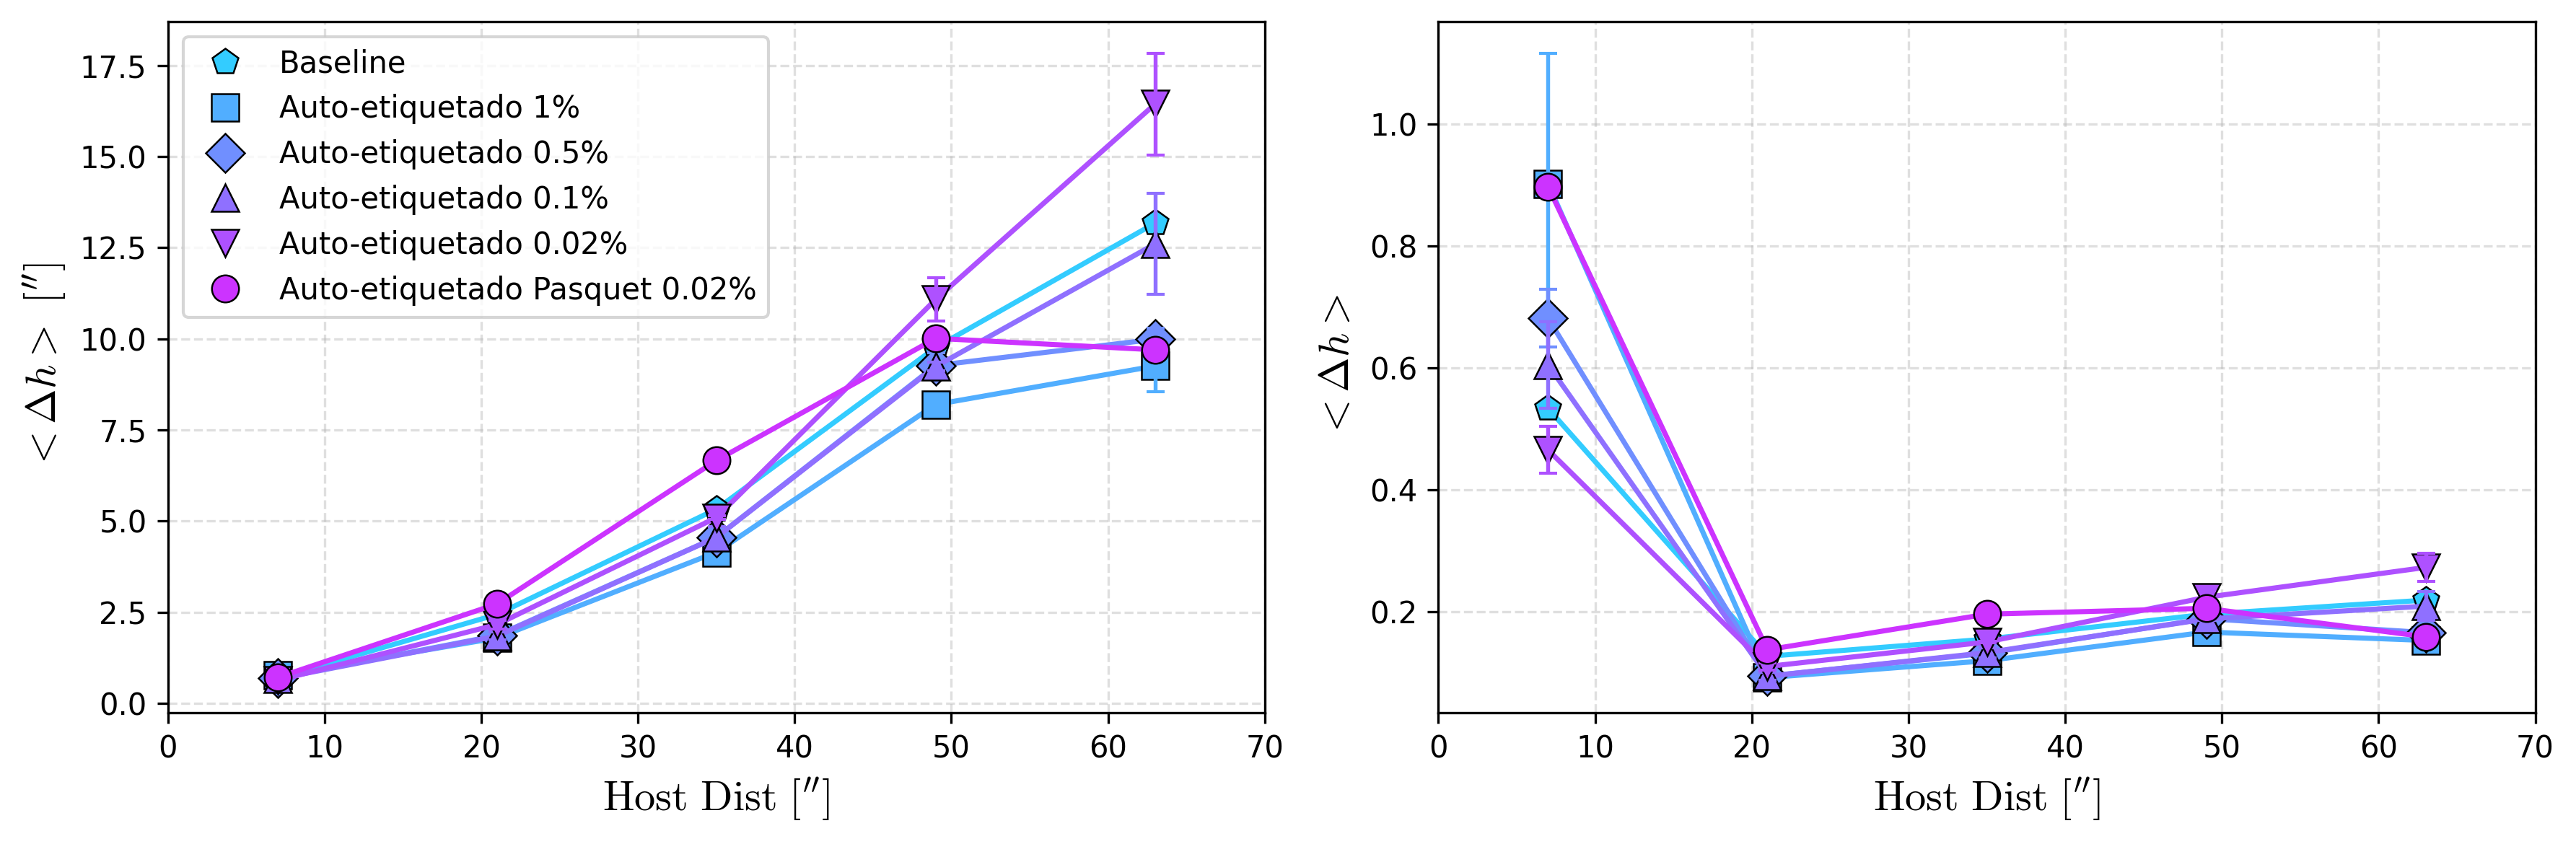

In [41]:
plot_binned_residuals_vs_host_dist_grouped(resultados, 
                                        experiments=experiments,                                             
                                        titles = names,
                                        cmap_name ="cool",
                                        n_bins=5,
                                        metric="bias",
                                        use_fill=False,
                                        fontsize=14,
                                        markers= ["p", "s", "D", "^", "v", "o"],
                                        alphas = [1,1,1,1,1,1],
                                        marker_size=9,
                                        dpi=300)

/tmp/ipykernel_3747957/2807202205.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


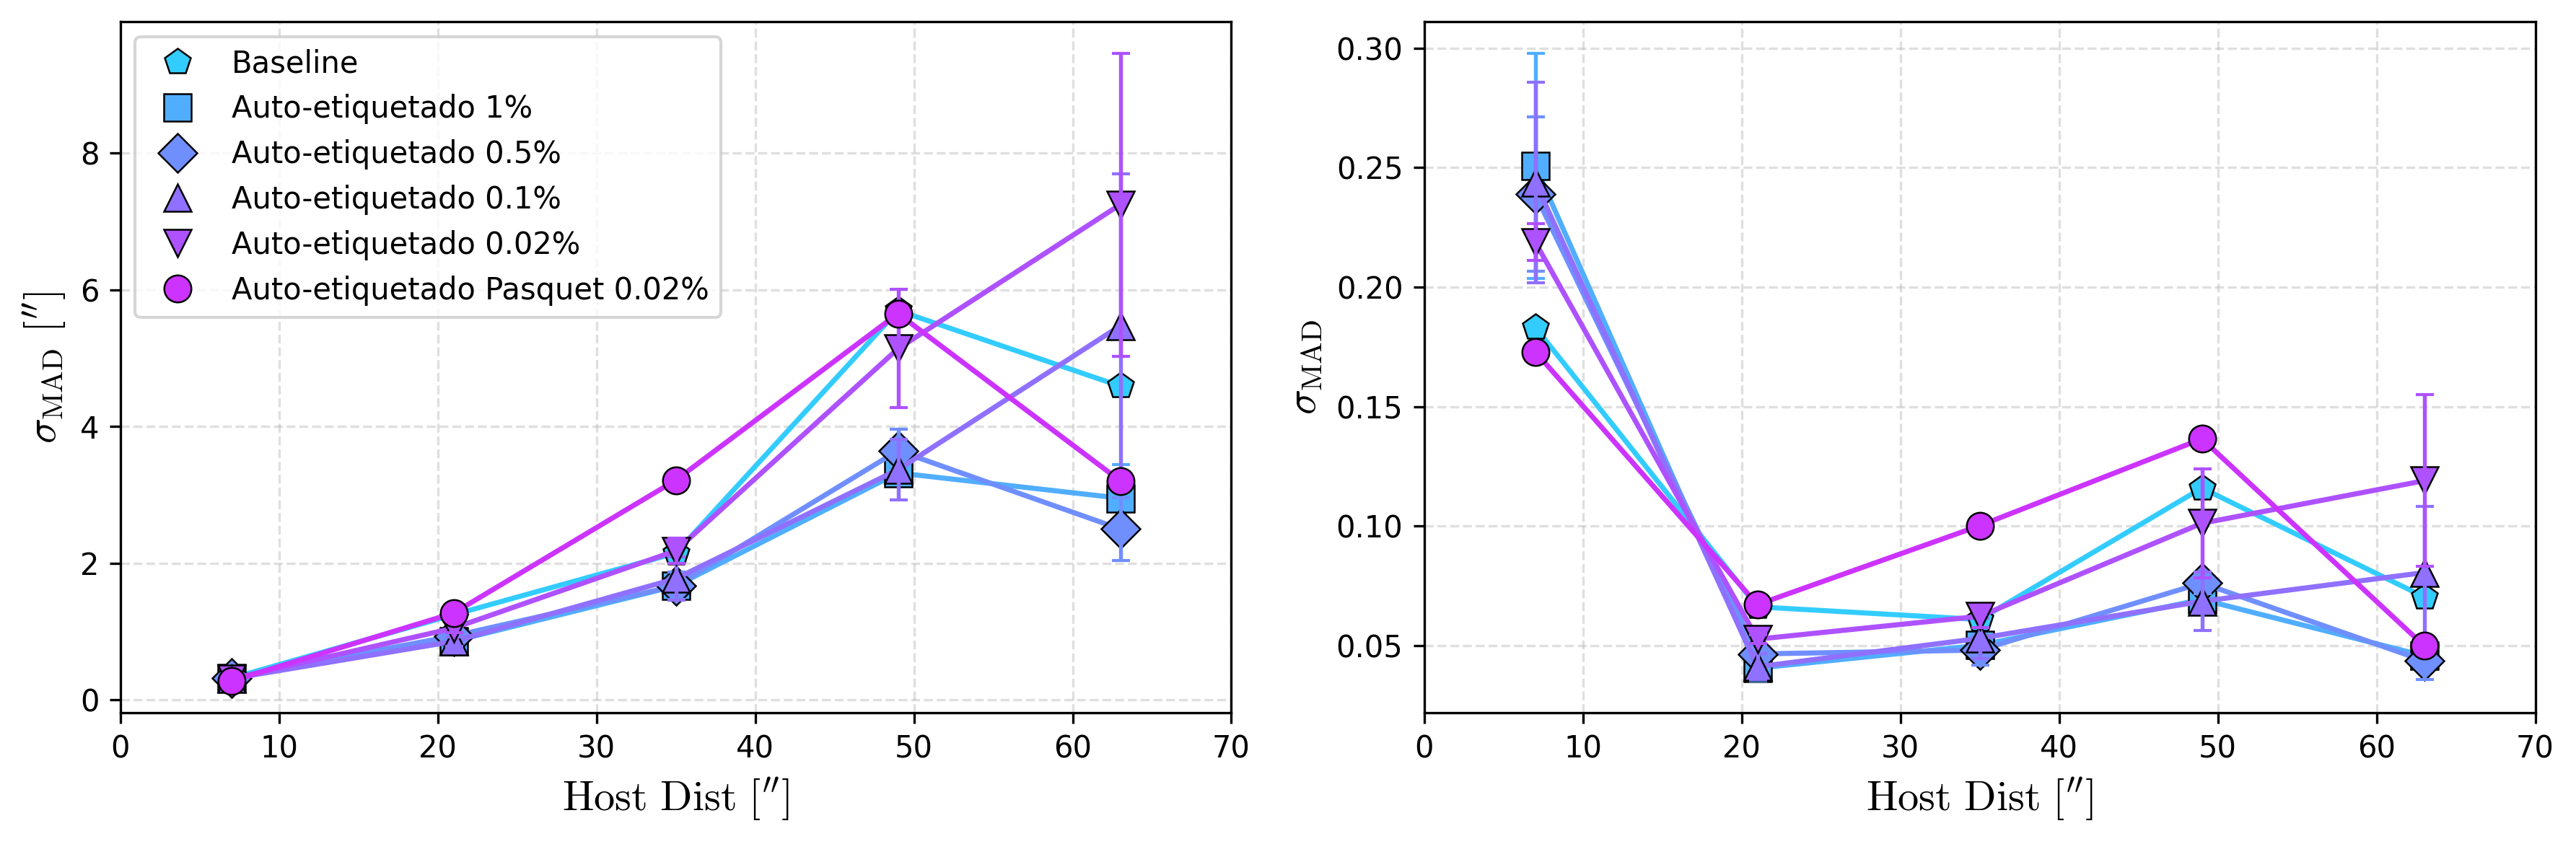

In [42]:
plot_binned_residuals_vs_host_dist_grouped(resultados, 
                                        experiments=experiments,                                             
                                        titles = names,
                                        cmap_name ="cool",
                                        n_bins=5,
                                        metric="nmad",
                                        use_fill=False,
                                        fontsize=14,
                                        markers= ["p", "s", "D", "^", "v", "o"],
                                        alphas = [1,1,1,1,1,1],
                                        marker_size=9,
                                        dpi=300)

In [38]:
experiments=[
["Original Galaxies"],
["Baseline"],
["Autolabeling 1% 1","Autolabeling 1% 2","Autolabeling 1% 3"],
["Autolabeling 05% 1","Autolabeling 05% 2","Autolabeling 05% 3"],
["Autolabeling 01% 1","Autolabeling 01% 2","Autolabeling 01% 3"],
["Autolabeling 002% 1","Autolabeling 002% 2","Autolabeling 002% 3"],
["Autolabeling Pasquet 002%"]

]

names = ["Original Galaxies","Baseline", "Autolabeling 1%", "Autolabeling 05%", "Autolabeling 01%", "Autolabeling 002%", "Auto-etiquetado Pasquet 002%"]

In [ ]:
metrics_cross_objid(galaxy_cross_match, experiments, names, "Original Galaxies")

## Redshift predictions

#### Bandas

In [ ]:
resultados = {

              "g": load_redshift_preds("redshift_center_on_galaxy_g_resnet18"),
              "gr": load_redshift_preds("redshift_center_on_galaxy_gr_resnet18"),
              "gri": load_redshift_preds("redshift_center_on_galaxy_gri_resnet18"),
              "griz": load_redshift_preds("redshift_center_on_galaxy_griz_resnet18"),
              "grizy": load_redshift_preds("redshift_center_on_galaxy_grizy_resnet18"),

              }

In [ ]:
bands = ["g", "gr", "gri", "griz", "grizy"]

zphot_list_gal = []
zspec_list_gal = []

for band in bands:

    z_phot1, z_spec1 = resultados[f"{band}"]

    zphot_list_gal.append(z_phot1)
    zspec_list_gal.append(z_spec1)

In [ ]:
plot_regresion_multi(zphots= zphot_list_gal, 
                     zspecs= zspec_list_gal, 
                     names=bands)

#### Modelos

In [ ]:
resultados = {

              "Redshift Center on SN DELIGHT": load_redshift_preds("redshift_center_on_sn_grizy_delight"),
              "Redshift Center on Galaxy DELIGHT": load_redshift_preds("redshift_center_on_galaxy_grizy_delight"),

              "Redshift Center on SN DELIGHT 2": load_redshift_preds("redshift_center_on_sn_grizy_delight", special_preds=True),
              "Redshift Center on Galaxy DELIGHT 2": load_redshift_preds("redshift_center_on_galaxy_grizy_delight", special_preds=True),

              "Redshift Center on SN Resnet18": load_redshift_preds("redshift_center_on_sn_grizy_resnet18"),

              "Redshift Center on SN Resnet32": load_redshift_preds("redshift_center_on_sn_grizy_resnet32"),
              #"Redshift Center on Galaxy Resnet32": load_redshift_preds("redshift_center_on_galaxy_g"),

              "Redshift Center on SN Pasquet": load_redshift_preds("redshift_center_on_sn_grizy_pasquet"),
              #"Redshift Center on Galaxy Pasquet": load_redshift_preds("redshift_center_on_galaxy_g"),

              }

In [ ]:
modelos = ["DELIGHT", "Resnet18", "Resnet32", "Pasquet"]


z_phot1, z_spec1 = resultados[f"Redshift Center on SN DELIGHT"]
z_phot2, z_spec2 = resultados[f"Redshift Center on SN Resnet18"]
z_phot3, z_spec3 = resultados[f"Redshift Center on SN Resnet32"]
z_phot4, z_spec4 = resultados[f"Redshift Center on SN Pasquet"]

plot_regresion_multi(zphots= [z_phot1,z_phot2,z_phot3,z_phot4], 
                     zspecs= [z_spec1,z_spec2,z_spec3,z_spec4], 
                     names=modelos)

In [ ]:
modelos = ["Center on SN", "Center on Galaxy"]


z_phot1, z_spec1 = resultados[f"Redshift Center on SN DELIGHT"]
z_phot2, z_spec2 = resultados[f"Redshift Center on SN DELIGHT 2"]

plot_regresion_multi(zphots= [z_phot1,z_phot2], 
                     zspecs= [z_spec1,z_spec2],
                     cmap="jet",
                     names=modelos,
                     dpi=300)

In [ ]:
modelos = ["Center on Galaxy", "Center on SN"]


z_phot3, z_spec3 = resultados[f"Redshift Center on Galaxy DELIGHT"]
z_phot4, z_spec4 = resultados[f"Redshift Center on Galaxy DELIGHT 2"]

plot_regresion_multi(zphots= [z_phot3,z_phot4], 
                     zspecs= [z_spec3,z_spec4],
                     cmap="jet",
                     names=modelos,
                     dpi=300)

In [ ]:
def obtain_inputs(dataset_path):

    data = np.load(dataset_path)

    X = data["imgs"]
    pos = torch.from_numpy(data["pos"])

    mask = (X.sum((3,4))==0).any((1,2)) # Casos con bandas == 0

    return pos[~mask]

In [ ]:
base_sersic_path = Path("..") / "data" / "SERSIC"
pos = obtain_inputs(dataset_path= base_sersic_path / "X_test_autolabeling_pasquet.npz")
host_dist = torch.norm(pos*0.25, dim=1)  

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(14,5),dpi=250)

plot_metrics_bins(z_spec1, 
                  [z_phot1,z_phot4], 
                  host_dist,
                  names = ["Entrenado Centrado en SN","Entrenado Centrado en Galaxia"],
                  alphas= [1,1,1,1,1],
                  fmts = ["s-","o-","^-","p-","D-"],
                  capsizes=[3,3,3,3,3],
                  n_bins=5,
                  metric = "bias",
                  cmap_name="cool",
                  figsize=(7,5),
                  dpi=200,
                  fontsize=14,
                  ylim=0.5,
                  ax=axs[0])


plot_metrics_bins(z_spec1, 
                  [z_phot1,z_phot4], 
                  host_dist,
                  names = ["Entrenado Centrado en SN","Entrenado Centrado en Galaxia"],
                  alphas= [1,1,1,1,1],
                  fmts = ["s-","o-","^-","p-","D-"],
                  capsizes=[3,3,3,3,3],
                  n_bins=5,
                  metric = "mad",
                  cmap_name="cool",
                  figsize=(7,5),
                  dpi=200,
                  fontsize=14,
                  ylim=0.1,
                  ax=axs[1])

plt.show()

In [ ]:
modelos = ["DELIGHT", "Resnet32", "Pasquet"]


z_phot1, z_spec1 = resultados[f"Redshift Center on SN DELIGHT"]
z_phot2, z_spec2 = resultados[f"Redshift Center on SN Resnet32"]
z_phot3, z_spec3 = resultados[f"Redshift Center on SN Pasquet"]

plot_regresion_multi(zphots= [z_phot1,z_phot2,z_phot3], 
                     zspecs= [z_spec1,z_spec2,z_spec3], 
                     names=modelos)

## Multi-task

#### Host identification

In [ ]:
resultados = {
              "Autolabeling Pasquet r 002%": load_preds("autolabeling_pasquet_r_002_percent"),
              "Autolabeling Pasquet grizy 002%": load_preds("autolabeling_pasquet_grizy_002_percent"),

              #"Redshift r": load_preds("redshift_center_on_sn_grizy_delight"),
              #"Redshift grizy": load_preds("redshift_center_on_sn_grizy_delight"),

              "Multitask gradnorm r": load_preds("multitaskt_delight_gradnorm_r_alpha0.01"),
              "Multitask gradnorm grizy": load_preds("multitaskt_delight_gradnorm_grizy_alpha0.01_2"),

              "Multitask no gradnorm r": load_preds("multitaskt_delight_nogradnorm_r"),
              "Multitask no gradnorm grizy": load_preds("multitaskt_delight_nogradnorm_grizy"),

              }

In [ ]:
experiments=[
["Autolabeling Pasquet r 002%"],
["Multitask no gradnorm r"],
["Multitask gradnorm r"],
]

names = ["Mono-tarea", "Multi-tarea", "Multi-tarea + GradNorm"]

In [ ]:
print_group_metrics(resultados, experiments, names)

In [ ]:
plot_residuals_vs_host_dist_grouped(resultados, 
                                    experiments=experiments,                                             
                                    titles = names,
                                    cmap_name ="cool",
                                    fontsize=14,
                                    fontsize_title=14,
                                    dpi=300)

In [ ]:
plot_binned_residuals_vs_host_dist_grouped(resultados, 
                                        experiments=experiments,                                             
                                        titles = names,
                                        cmap_name ="cool",
                                        n_bins=5,
                                        metric="bias",
                                        use_fill=False,
                                        fontsize=14,
                                        markers= ["p", "s", "D"],
                                        alphas = [1,1,1],
                                        marker_size=9,
                                        dpi=300)

In [ ]:
plot_binned_residuals_vs_host_dist_grouped(resultados, 
                                        experiments=experiments,                                             
                                        titles = names,
                                        cmap_name ="cool",
                                        n_bins=5,
                                        metric="nmad",
                                        use_fill=False,
                                        fontsize=14,
                                        markers= ["p", "s", "D"],
                                        alphas = [1,1,1],
                                        marker_size=9,
                                        dpi=300)

In [ ]:
plot_binned_residuals_vs_host_dist_grouped(resultados, 
                                        experiments=experiments,                                             
                                        titles = names,
                                        cmap_name ="cool",
                                        n_bins=5,
                                        metric="nmad",
                                        use_fill=False,
                                        fontsize=14,
                                        markers= ["p", "s", "D"],
                                        alphas = [1,1,1],
                                        marker_size=9,
                                        dpi=200)

In [ ]:
experiments=[
["Autolabeling Pasquet r 002%"],
["Multitask no gradnorm r"],
["Multitask gradnorm r"],
]

names = ["Mono-tarea", "Multi-tarea", "Multi-tarea + GradNorm"]

In [ ]:
galaxy_cross_match = {

    "Original Galaxies": pd.read_csv(
        "../data/SERSIC/df_test_delight_fixed_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Autolabeling Pasquet r 002%": pd.read_csv(
        "../resultados/autolabeling_pasquet_r_002_percent/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Multitask no gradnorm r": pd.read_csv(
        "../resultados/multitaskt_delight_nogradnorm_r/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Multitask gradnorm r": pd.read_csv(
        "../resultados/multitaskt_delight_gradnorm_grizy_alpha0.01_2/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),


}

experiments=[
["Original Galaxies"],
["Autolabeling Pasquet r 002%"],
["Multitask no gradnorm r"],
["Multitask gradnorm r"],
]

names = ["Original Galaxies","Mono-tarea", "Multi-tarea", "Multi-tarea + GradNorm"]

metrics_cross_objid(galaxy_cross_match, experiments, names, "Original Galaxies")

#### Redshift

In [ ]:
resultados = {
              #"Autolabeling Pasquet r 002%": load_redshift_preds("autolabeling_pasquet_r_002_percent"),
              #"Autolabeling Pasquet grizy 002%": load_redshift_preds("autolabeling_pasquet_grizy_002_percent"),

              "Redshift r": load_redshift_preds("redshift_center_on_sn_grizy_delight"),
              "Redshift grizy": load_redshift_preds("redshift_center_on_sn_grizy_delight"),
              "Redshift grizy center gal": load_redshift_preds("redshift_center_on_galaxy_grizy_delight"),

              "Multitask gradnorm r": load_redshift_preds("multitaskt_delight_gradnorm_r_alpha0.01"),
              "Multitask gradnorm grizy": load_redshift_preds("multitaskt_delight_gradnorm_grizy_alpha0.01_2"),

              "Multitask no gradnorm r": load_redshift_preds("multitaskt_delight_nogradnorm_r"),
              "Multitask no gradnorm grizy": load_redshift_preds("multitaskt_delight_nogradnorm_grizy"),

              }

In [ ]:
bands = ["Redshift grizy", "Multitask no gradnorm grizy", "Multitask gradnorm grizy"]

zphot_list_gal = []
zspec_list_gal = []

for band in bands:

    z_phot1, z_spec1 = resultados[f"{band}"]

    zphot_list_gal.append(z_phot1)
    zspec_list_gal.append(z_spec1)

In [ ]:
names = ["Mono-tarea", "Multi-tarea", "Multi-tarea + GradNorm"]
plot_regresion_multi(zphots= zphot_list_gal, 
                     zspecs= zspec_list_gal, 
                     names=names)

In [ ]:
bands = ["Redshift grizy center gal", "Multitask gradnorm grizy"]

zphot_list_gal = []
zspec_list_gal = []

for band in bands:

    z_phot1, z_spec1 = resultados[f"{band}"]

    zphot_list_gal.append(z_phot1)
    zspec_list_gal.append(z_spec1)

In [ ]:
names = ["Mono-tarea center on galaxy", "Multi-tarea + GradNorm"]
plot_regresion_multi(zphots= zphot_list_gal, 
                     zspecs= zspec_list_gal, 
                     names=names)

In [ ]:
bands = ["Redshift r", "Multitask no gradnorm r", "Multitask gradnorm r"]

zphot_list_gal = []
zspec_list_gal = []

for band in bands:

    z_phot1, z_spec1 = resultados[f"{band}"]

    zphot_list_gal.append(z_phot1)
    zspec_list_gal.append(z_spec1)

In [ ]:
names = ["Mono-tarea", "Multi-tarea", "Multi-tarea + GradNorm"]
plot_regresion_multi(zphots= zphot_list_gal, 
                     zspecs= zspec_list_gal, 
                     names=names)

## Anexo

In [ ]:
resultados = {
              "DELIGHT": load_preds("baseline_delight_r"),
              "Resnet18": load_preds("baseline_resnet18_r"),
              "Resnet32": load_preds("baseline_resnet32_r"),
              "Pasquet": load_preds("baseline_pasquet_r_2"),


              "DELIGHT auto 1": load_preds("autolabeling_delight_r_05_percent_1"),
              "DELIGHT auto 2": load_preds("autolabeling_delight_r_05_percent_2"),
              "DELIGHT auto 3": load_preds("autolabeling_delight_r_05_percent_3"),

              "Resnet18 auto 1": load_preds("autolabeling_resnet18_r_05_percent_1"),
              "Resnet18 auto 2": load_preds("autolabeling_resnet18_r_05_percent_2"),
              "Resnet18 auto 3": load_preds("autolabeling_resnet18_r_05_percent_3"),

              "Resnet32 auto 1": load_preds("autolabeling_resnet32_r_05_percent_1"),
              "Resnet32 auto 2": load_preds("autolabeling_resnet32_r_05_percent_2"),
              "Resnet32 auto 3": load_preds("autolabeling_resnet32_r_05_percent_3"),

              "Pasquet auto 1": load_preds("autolabeling_pasquet_r_05_percent_1"),
              "Pasquet auto 2": load_preds("autolabeling_pasquet_r_05_percent_2"),
              "Pasquet auto 3": load_preds("autolabeling_pasquet_r_05_percent_3"),
              }


In [ ]:
experiments=[
["DELIGHT auto 1", "DELIGHT auto 2", "DELIGHT auto 3"],
["Resnet18 auto 1", "Resnet18 auto 2", "Resnet18 auto 3"],
["Resnet32 auto 1", "Resnet32 auto 2", "Resnet32 auto 3"],
["Pasquet auto 1", "Pasquet auto 2", "Pasquet auto 3"],
]

names = ["DELIGHT","Resnet18","Resnet32","Pasquet"]

In [ ]:
experiments=[
["DELIGHT"],
["Resnet18"],
["Resnet32"],
["Pasquet"],
]

names = ["DELIGHT","Resnet18","Resnet32","Pasquet"]

In [ ]:
print_group_metrics(resultados, experiments, names)

In [ ]:
plot_residuals_vs_host_dist_grouped(resultados, 
                                    experiments=experiments,                                             
                                    titles = names,
                                    cmap_name ="cool",
                                    fontsize=16,
                                    fontsize_title=16,
                                    dpi=300)

In [ ]:
galaxy_cross_match = {

    "Original Galaxies": pd.read_csv(
        "../data/SERSIC/df_test_delight_fixed_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "DELIGHT": pd.read_csv(
        "../resultados/baseline_delight_r/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Resnet18": pd.read_csv(
        "../resultados/baseline_resnet18_r/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Resnet32": pd.read_csv(
        "../resultados/baseline_resnet32_r/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Pasquet": pd.read_csv(
        "../resultados/baseline_pasquet_r_2/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

}

experiments=[
["DELIGHT"],
["Resnet18"],
["Resnet32"],
["Pasquet"],
]

names = ["DELIGHT","Resnet18","Resnet32","Pasquet"]

metrics_cross_objid(galaxy_cross_match, experiments, names, "Original Galaxies")

In [ ]:
galaxy_cross_match = {

    "Original Galaxies": pd.read_csv(
        "../data/SERSIC/df_test_delight_fixed_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "DELIGHT 1": pd.read_csv(
        "../resultados/autolabeling_delight_r_05_percent_1/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "DELIGHT 2": pd.read_csv(
        "../resultados/autolabeling_delight_r_05_percent_2/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "DELIGHT 3": pd.read_csv(
        "../resultados/autolabeling_delight_r_05_percent_3/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Resnet18 1": pd.read_csv(
        "../resultados/autolabeling_resnet18_r_05_percent_1/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Resnet18 2": pd.read_csv(
        "../resultados/autolabeling_resnet18_r_05_percent_2/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Resnet18 3": pd.read_csv(
        "../resultados/autolabeling_resnet18_r_05_percent_3/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Resnet32 1": pd.read_csv(
        "../resultados/autolabeling_resnet32_r_05_percent_1/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Resnet32 2": pd.read_csv(
        "../resultados/autolabeling_resnet32_r_05_percent_2/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Resnet32 3": pd.read_csv(
        "../resultados/autolabeling_resnet32_r_05_percent_3/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Pasquet 1": pd.read_csv(
        "../resultados/autolabeling_pasquet_r_05_percent_1/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Pasquet 2": pd.read_csv(
        "../resultados/autolabeling_pasquet_r_05_percent_2/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

    "Pasquet 3": pd.read_csv(
        "../resultados/autolabeling_pasquet_r_05_percent_3/test_predictions_objid.csv",
        dtype={"sdss_objid": "Int64"}
    ),

}

experiments=[
["Original Galaxies"],
["DELIGHT 1", "DELIGHT 2","DELIGHT 3"],
["Resnet18 1","Resnet18 2","Resnet18 3"],
["Resnet32 1", "Resnet32 2", "Resnet32 3"],
["Pasquet 1", "Pasquet 2", "Pasquet 3"],
]

names = ["Original Galaxies", "DELIGHT","Resnet18","Resnet32","Pasquet"]

metrics_cross_objid(galaxy_cross_match, experiments, names, "Original Galaxies")

## Para generar OIDs

In [ ]:
# paths = [
# "autolabeling_pasquet_grizy_002_percent",


# "multitaskt_delight_gradnorm_r_alpha0.01",
# "multitaskt_delight_gradnorm_grizy_alpha0.01_2",

# "multitaskt_delight_nogradnorm_r",
# "multitaskt_delight_nogradnorm_grizy"
# ]

# for path in paths:

#     df =sdss_crossmatch_joblib(f"/home/acontreras/PRISM/resultados/{path}/test_predictions.csv", ra_col="ra_pred", dec_col="dec_pred")
#     df.to_csv(f"/home/acontreras/PRISM/resultados/{path}/test_predictions_objid.csv", index=False)